# Understandable implemetation of VEGAS algorithm by Timur Khuzin

Sources:
1. https://e-maxx.ru/bookz/files/numerical_recipes.pdf, pp. 414-416
2. http://numerical.recipes/webnotes/nr3web9.pdf

Created in December, 2018. <br>
By Timur Khuzin. <br>
https://github.com/AngelicosPhosphoros/VEGAS <br>
http://angelicosphosphoros.pythonanywhere.com/ <br>
xuzin.timur@gmail.com <br>
tvkhuzin@edu.hse.ru

## How it works

Vegas is the algorithm of adaptive integration.<br>
It divide each dimension in equal number of bins (let it be *N*). Total integral calculated as sum of all subintegrals for all combination of bins (total $N^{dim}$ combinations). Since it store bins by each dimension, total number of stored grid elements is $N*dim$.<br><br>
Initially each dimension has equally distributed bins.
After each epoch of calculation, bins are resized using weights in each dimension independently. The resize algorithm has these arguments: $\alpha$ is regularization weight, *old_weights* is vector of old weights, *subintegrals* which is array with *N* rows and *dim* columns, which contains sum of subintegrals of absolute value of func in bin.<br>
1) Calculated new weights of old bins
$$w_i = \frac{1}{\alpha*Mean(subintegrals)+subintegrals_i}$$
2) Normalize *w* to make $\sum_{i=1}^{N}w_i=1$ <br>
3) Calculate updated weights as multiplication of old weights on new ones, then normalize them.
4) Calculate new bins using updated weights.

In [15]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [16]:
import numpy as np
import numpy.random
from sklearn.preprocessing import normalize
from matplotlib.pyplot import plot

In [25]:
%%cython

cimport cython
cimport numpy as cnp
import numpy as np

@cython.boundscheck(False)
cdef _get_selected_region(total_region, bins, indices):
    '''
    I rewritten bottleneck in Cython to speed up algorithm.
    See Vegas.get_selected_region for details.
    '''
    cdef double[:,:] region = total_region
    cdef cnp.npy_intp [:] indices_view = indices
    result = np.empty((2, len(indices)))
    cdef double[:, :] result_view = result
    cdef double[:, :] bins_view = bins 
    cdef Py_ssize_t index
    cdef Py_ssize_t lower_index
    cdef Py_ssize_t max_index = bins.shape[0] - 1 
    cdef double tot_range
    cdef cnp.npy_intp length = len(indices)
    for dim in range(length):
        tot_range = region[1,dim] - region[0,dim]
        index = indices_view[dim]
        lower_index = index - 1 
        # [-1] element is left border for bin[0]
        # so actually we need len(x)-1
        if not index:
            lower_index = max_index
        result_view[0,dim] = region[0, dim] + bins_view[lower_index, dim] * tot_range
        result_view[1,dim] = region[0, dim] + bins_view[index, dim] * tot_range
    return result

def cython_get_selected_region(total_region, bins, indices):
    return _get_selected_region(total_region, bins, indices)

In [27]:
class Vegas:
    '''
    Class for integral calculation by VEGAS algorithm.
    It works in two steps.
    At first step, it divide each dimension in equal number of bins per dimension.
    Than it estimate importance of each bin in each dimesnion using absolute value of integrals in each bin.
    After that it make more important bins smaller and less important bins larger.
    At second step it calculate integrals in each subregion defined by bins and calculate sum of them as integral.
    
    Since bins have different sizes and the number of calls are equal for all bins, 
    more imporant ranges of function arguments receive more calls, so result estimation of integral are better.
    
    params:
        region      matrix of [2,Dim], where [0,:] is lower limit, [1,:] is upper limit of func args.
                    Dim is the number of dimensions
        func        function to be integrated
        rand        Just random generator in range [0,1)
    '''
    def __init__(self, region, func, rand=np.random.RandomState(seed=164)):
        self.region = np.array(region, dtype=float)
        self.func = func
        self.dimensions = region.shape[1]
        self.rand = rand
    
    @staticmethod
    def resize_grid(grid, old_weights, subintegrals, alpha):
        '''
        This method resize grid using value of subintegrals on each bin.
        Values of bins for each dimension calculated independently.
        params:
            grid           MUTABLE. grid to be adjusted
            old_weights    Weights which were used to generate old grid
            subintegrals   Values of mean subintegrals for each bin
            alpha          Multiplier on regularization part of weight calculation
        returns:
            grid           Just reference to passed argument
            weights        Updated weights of each bin in each dimension, with shape=[bin_num,Dim]
        '''
        dimensions = len(grid[0,:])
        
        # adjust each dimension independently
        mean = np.mean(subintegrals, axis=0)
        mean[mean==0] = 1 # We just try to avoid NaNs
        rel_weights = 1/(alpha*mean+subintegrals)
        # division works along columns
        rel_weights = rel_weights/np.sum(rel_weights, axis=0)
        
        # Accuratize old weights
        combined_weights = old_weights * rel_weights
        combined_weights = combined_weights / np.sum(combined_weights, axis=0)
        # Resize bins using weights
        for dim in range(dimensions):
            for i, w in enumerate(combined_weights[:,dim]):
                grid[i,dim] = grid[i-1,dim] + w
        return grid, combined_weights
            
    @staticmethod
    def get_next_index(indices, limit):
        '''Returns next index in "little-endian" way'''
        for i in range(len(indices)):
            indices[i] = (indices[i]+1)%limit
            if indices[i]:
                return
            
    def get_selected_subregion(self, bins, indices):
        '''
        Get subregion of shape [2,Dim] total region.
        result[0,:] is lower bound of selected region, result[1,:] is upper bound
        '''
        return cython_get_selected_region(self.region, bins, indices)
        # Those code was slow so rewritten on cython
        # region = self.region
        # lower_indices = indices - 1
        # result = np.empty((2, len(indices)))
        # for dim in range(len(indices)):
        #    result[0,dim] = bins[lower_indices[dim], dim]
        #    result[1,dim] = bins[indices[dim], dim]
        # total_range = (region[1,:]-region[0,:])
        # result[0,:] = region[0,:] + total_range*result[0,:]
        # result[1,:] = region[0,:] + total_range*result[1,:]
        # return result
    
    def prepare_grid(self, bins_per_dimension=50, epochs=100, calls_per_epoch=2500, alpha=1.0):
        '''
        Create adjusted grid to calculate VEGAS.
        Regions with bigger absolute value of func tends to be smaller, and regions with values->0  tends to be larger.
        params:
            bins_per_dimension    number of bins in each dimension
            epochs                number of times grid recalculated
            calls_per_epoch       number of call in each epoch. In each bin will be calls_per_epoch/(total_bins) calls
            alpha                 float parameter that change speed of fitting. Larger will slow fitting (see `resize_grid`)
        '''
        
        if alpha<=np.finfo(float).eps:
            raise Exception("To low alpha")
        
        # bin values are ranged from 0 to 1
        # I keep right borders of bins
        # so I need to add [-1] row to calculate left border for bin0
        # bins are kept by rows, and dimension indices are associated with columns
        bin_num = bins_per_dimension
        dimensions = len(self.region[0,:])
        bins = np.empty((bin_num+1, dimensions))
        weights = np.empty((bin_num, dimensions))
        # We use uniform distribution to start
        vals = np.arange((1/bin_num),1 + (1/bin_num),1/bin_num)
        vals = np.append(vals, 0) # [-1] element is left border for bin[0]
        ws = np.ones(bin_num)/bin_num
        for dim in range(dimensions):
            bins[:, dim] = vals
            weights[:, dim] = ws
        del vals
        del ws
        
        # number of combinations by each dim
        total_bins = bin_num**dimensions
        calls_per_bin = min(calls_per_epoch//total_bins,2)
        # Let resize grid
        for epoch in range(epochs):
            selected_bins = np.zeros(dimensions, dtype=np.intp) # indices
            distrib = np.zeros((bin_num, dimensions), dtype=float) # To keep sum of integrals
            
            for _ in range(total_bins):
                selected_zone = self.get_selected_subregion(bins, selected_bins)
                volume = np.prod(selected_zone[1,:] - selected_zone[0,:])
                mean_importance = 0
                for step in range(calls_per_bin):
                    rand_point = self.rand.rand(dimensions)
                    call_res = self.func(selected_zone[0,:] + rand_point*(selected_zone[1,:]-selected_zone[0,:]))
                    mean_importance += volume * np.abs(call_res) / calls_per_bin
                for i, j in zip(selected_bins, range(dimensions)):
                    distrib[i,j] += mean_importance
                Vegas.get_next_index(selected_bins, bin_num)

            bins, weights = Vegas.resize_grid(bins, weights, distrib, alpha)
            
        
        # All correct, so we can modify model state
        self.bin_num = bin_num
        self.dimensions = dimensions
        self.bins = bins
    
    def integrate(self, times=20, number_of_calls=10000):
        '''
        Final integration.
        Calculate small integral in each bin combination (hypercube) in volume and summarize it.
        It evaluate integral independently few times, then average it.
        param:
            times            how many independent evaluations to make
            number_of_calls  how many Monte-Carlo calls in each evaluation
        returns:
            integral         Mean of all evaluations
            std_error        Square root of dispertion
        '''
        if times<=0 or number_of_calls<=0:
            raise Exception("Incorrect params")
            
        bins, bin_num, dimensions = self.bins, self.bin_num, self.dimensions
        
        total_bins = bin_num**dimensions
        calls_per_bin = max(number_of_calls//total_bins,2)
        evaluations = []
        for _ in range(times):
            selected_bins = np.zeros(dimensions, dtype=np.intp) # indices
            integral = 0
            for _ in range(total_bins):
                selected_zone = self.get_selected_subregion(bins, selected_bins)
                volume = np.prod(selected_zone[1,:] - selected_zone[0,:])
                little_integral = 0
                for step in range(calls_per_bin):
                    rand_point = self.rand.rand(dimensions)
                    call_res = self.func(selected_zone[0,:] + rand_point*(selected_zone[1,:]-selected_zone[0,:]))
                    little_integral += volume * call_res / calls_per_bin

                integral += little_integral
                Vegas.get_next_index(selected_bins, bin_num)
            evaluations.append(integral)
        
        return np.mean(evaluations), np.var(evaluations)**0.5


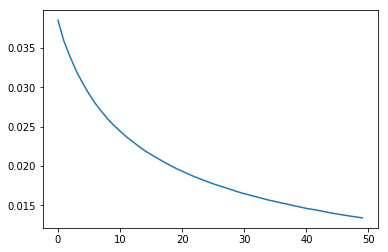

In [31]:
# Test cases

def rnd(vect):
    '''This is sphere with R=1 and center in {1..1}'''
    if np.sum((vect-1)*(vect-1))<1:
        return 1
    return 0

def grow(vect):
    return np.sum(vect)/4

model = Vegas(np.array([[0,0],[2,2]]), grow)
model.prepare_grid(epochs=50)

# let's plot weights of bins along one dimension
v = model.bins[:,0]
v = [v[i]-v[i-1] for i in range(len(v)-1)]
plot(v)

In [32]:
model.integrate()

(1.9999568927731228, 0.0002420733078483813)

In [33]:
def proc():
    model2 = Vegas(np.array([[0,0,0],[2,2,2]]), rnd)
    model2.prepare_grid(epochs=10)
    return model2.integrate(times=5)
# %prun proc()
proc()

(4.189228800002878, 0.001455996483513619)

In [34]:
np.pi*4/3

4.1887902047863905